Mean Load: 50 ; Variance Load: 10


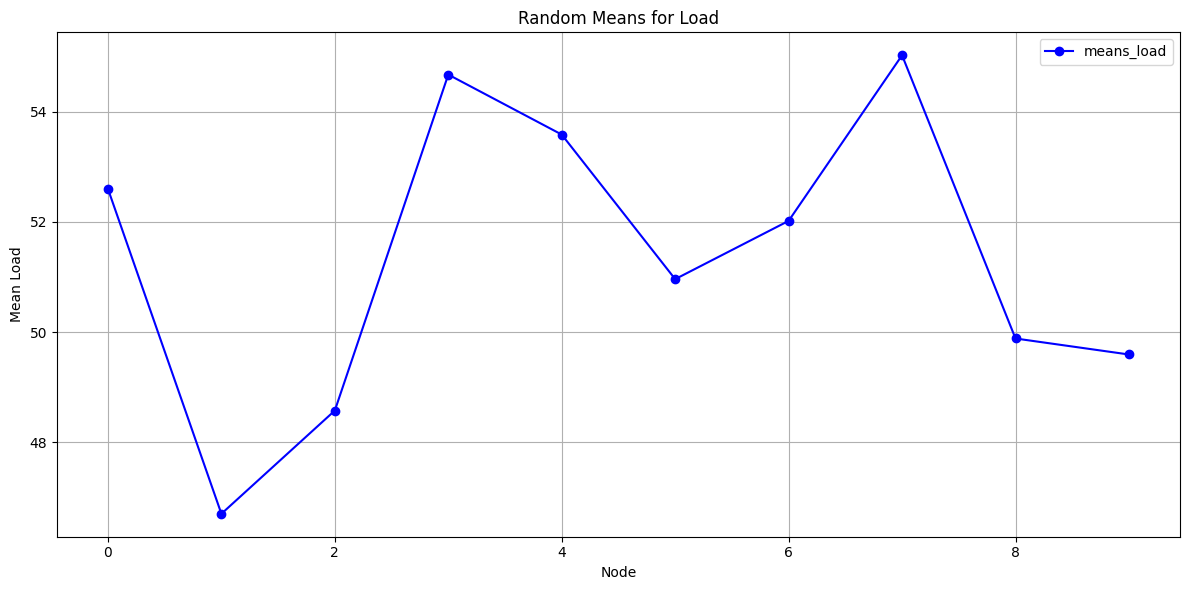

[52.59859583 46.70393574 48.57725619 54.67234909 53.58412187 50.96118601
 52.01823309 55.02326752 49.88441381 49.59416141]


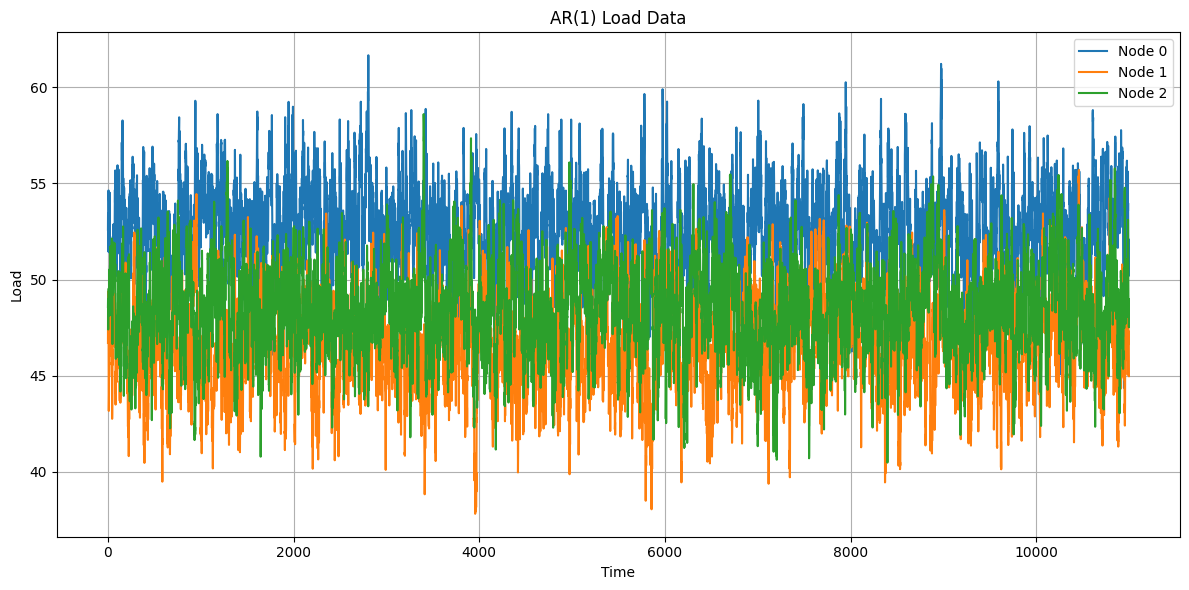

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import networkx as nx


# Function to generate random means
def generate_means(N, mean_load, var_load):
    print('Mean Load:', mean_load, '; Variance Load:', var_load)
    means_load = np.random.normal(loc=mean_load, scale=np.sqrt(var_load), size=N)

    # Plotting means_load
    plt.figure(figsize=(12, 6))
    plt.plot(means_load, marker='o', linestyle='-', color='b', label='means_load')
    plt.title('Random Means for Load')
    plt.xlabel('Node')
    plt.ylabel('Mean Load')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return means_load


# Function to generate IID data
def generate_iid_data(N, T, means_load):
    loads = np.array([np.random.normal(loc=means_load[i], scale=1, size=T) for i in range(N)])

    return loads, np.mean(loads, axis=1)


# Function to generate AR(1) data
def generate_ar1_data(N, T, means_load, theta):
    loads = np.zeros((N, T))

    def generate_ar1(theta, T, mean_node):
        ar1 = np.zeros(T)
        ar1[0] = mean_node
        for t in range(1, T):
            ar1[t] = theta * ar1[t - 1] + (1 - theta) * mean_node + np.random.normal(0, 1)
        return ar1

    for i in range(N):
        loads[i] = generate_ar1(theta, T, means_load[i])

    return loads, np.mean(loads, axis=1)


# 绘制指定范围内的AR(1)数据
def plot_ar1_data(load_data, start, end):
    N, T = load_data.shape
    time_steps = np.arange(start, end)

    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.plot(time_steps, load_data[i, start:end], label=f'Node {i}')
    plt.title('AR(1) Load Data')
    plt.xlabel('Time')
    plt.ylabel('Load')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()


N = 10
T_train = 10000
T_test = 1000
T = T_train + T_test
mean_load = 50
var_load = 10

means_load = generate_means(N, mean_load, var_load)
print(means_load)

# Generate IID data
load_iid, load_iid_means = generate_iid_data(N, T, means_load)

# Generate AR(1) data
theta = 0.9
load_ar1, load_ar1_means = generate_ar1_data(N, T, means_load, theta)
# Plotting AR(1) data
plot_ar1_data(load_ar1[:3], 0, T)

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch.utils.data import Dataset, DataLoader

In [3]:
data = load_ar1

# 将数据转换为张量
train_data = torch.tensor(data[:, :T_train], dtype=torch.float32)
test_data = torch.tensor(data[:, T_train:], dtype=torch.float32)
# 超参数定义
batch_size = 32  # 批量大小
seq_length = 20  # 序列长度
input_size = 10  # 输入的节点数量
output_size = 10  # 输出的节点数量，和输入相同
learning_rate = 0.001  # 学习率


# 切分时间序列为多个样本
def create_sequences(data, seq_length, T_train):
    sequences = []
    targets = []
    for i in range(T_train - seq_length):
        # 循环次数不是T_train - seq_length + 1，因为训练集里并没有第10001个真实数据作为target。
        # 最后一次生成的序列会在逐步更新的过程中使用，而不是在初始训练集中。
        seq = data[:, i: i + seq_length].T  # 提取每个时间步的序列
        target = data[:, i + seq_length]  # 提取目标值
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


# 生成训练集
sequences, targets = create_sequences(train_data, seq_length, T_train)
sequences = torch.tensor(sequences, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

print(f'sequences shape: {sequences.shape}')
print(f'targets shape: {targets.shape}')
# 创建数据加载器
train_dataset = TensorDataset(sequences, targets)
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f'Number of batches: {len(dataloader)}')
print(f'size of input x: {sequences.shape}')
for i, batch in enumerate(dataloader):
    inputs, targets = batch
    print(f'{i:>3}: inputs.shape: {inputs.shape}, targets.shape: {targets.shape}')

sequences shape: torch.Size([9980, 20, 10])
targets shape: torch.Size([9980, 10])
Number of batches: 312
size of input x: torch.Size([9980, 20, 10])
  0: inputs.shape: torch.Size([32, 20, 10]), targets.shape: torch.Size([32, 10])
  1: inputs.shape: torch.Size([32, 20, 10]), targets.shape: torch.Size([32, 10])
  2: inputs.shape: torch.Size([32, 20, 10]), targets.shape: torch.Size([32, 10])
  3: inputs.shape: torch.Size([32, 20, 10]), targets.shape: torch.Size([32, 10])
  4: inputs.shape: torch.Size([32, 20, 10]), targets.shape: torch.Size([32, 10])
  5: inputs.shape: torch.Size([32, 20, 10]), targets.shape: torch.Size([32, 10])
  6: inputs.shape: torch.Size([32, 20, 10]), targets.shape: torch.Size([32, 10])
  7: inputs.shape: torch.Size([32, 20, 10]), targets.shape: torch.Size([32, 10])
  8: inputs.shape: torch.Size([32, 20, 10]), targets.shape: torch.Size([32, 10])
  9: inputs.shape: torch.Size([32, 20, 10]), targets.shape: torch.Size([32, 10])
 10: inputs.shape: torch.Size([32, 20, 10

In [4]:
# # 定义LSTM模型
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers=1):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)
# 
#     def forward(self, x):
#         # 初始化隐藏状态和细胞状态为零
#         h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
# 
#         out, _ = self.lstm(x, (h_0, c_0))
#         out = self.fc(out[:, -1, :])
#         return out


In [5]:
class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)
        self.rnn = torch.nn.GRU(out_channels, out_channels, batch_first=True)
        self.fc = torch.nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index):
        batch_size, seq_len, num_nodes = x.size()

        # Apply GCNConv to each time step individually
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)

        # Pass the transformed features through GRU
        out, _ = self.rnn(x)

        # Use the last time step's output to predict the next time step's node values
        out = self.fc(out[:, -1, :])  # Shape [batch_size, num_nodes]
        return out

In [6]:
# 假设一个简单的完全图结构（每个节点都与其他节点相连）
edge_index = torch.tensor(np.array([(i, j) for i in range(N) for j in range(N)]).T, dtype=torch.long)
print(edge_index)

# 初始化模型
model = GNNModel(in_channels=input_size, out_channels=output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
         9, 9, 9, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
         4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
         8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
         2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
         6, 7, 8, 9]])


In [7]:
%%time
num_epochs = 100  # 训练的轮次

model.train()
for epoch in tqdm(range(num_epochs), desc="Training"):
    for inputs, targets in dataloader:
        # 前向传播
        outputs = model(inputs, edge_index)
        loss = criterion(outputs, targets)

        # 反向传播和优化
        optimizer.zero_grad()# 清除之前的梯度
        loss.backward()  # 反向传播，计算梯度
        optimizer.step()  # 更新参数

    # 每10轮输出一次损失
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        # 清理缓存
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

Training:  10%|█         | 10/100 [00:35<05:09,  3.43s/it]

Epoch [10/100], Loss: 686.0252


Training:  20%|██        | 20/100 [01:09<04:29,  3.37s/it]

Epoch [20/100], Loss: 33.4963


Training:  30%|███       | 30/100 [01:43<04:04,  3.50s/it]

Epoch [30/100], Loss: 4.7557


Training:  40%|████      | 40/100 [02:16<03:25,  3.43s/it]

Epoch [40/100], Loss: 5.8097


Training:  50%|█████     | 50/100 [02:50<02:50,  3.41s/it]

Epoch [50/100], Loss: 4.7980


Training:  60%|██████    | 60/100 [03:25<02:40,  4.02s/it]

Epoch [60/100], Loss: 4.8494


Training:  70%|███████   | 70/100 [03:52<01:08,  2.28s/it]

Epoch [70/100], Loss: 5.0408


Training:  80%|████████  | 80/100 [04:12<00:38,  1.90s/it]

Epoch [80/100], Loss: 4.9360


Training:  90%|█████████ | 90/100 [04:32<00:19,  1.98s/it]

Epoch [90/100], Loss: 5.4809


Training: 100%|██████████| 100/100 [04:52<00:00,  2.92s/it]

Epoch [100/100], Loss: 5.0661
CPU times: total: 1min 58s
Wall time: 4min 52s


In [11]:
%%time
total_loss = 0

# 保存预测值和真实值
predictions = []
true_values = []

# 初始化测试输入，使用训练集的最后一个序列
x_test = train_data[:, -seq_length:].T.unsqueeze(0)  # 形状为 [1, 20, 10]
print(f'Initial input shape: {x_test.shape}')

for i in range(T_test):
    # 模型保持在训练模式，以便进行微调
    model.train()

    # 预测当前时间步的值
    # with torch.no_grad():
    pred = model(x_test, edge_index)  # 形状为 [1, 10]

    # 获取当前真实值
    real_value = test_data[:, i]  # 形状为 [10]

    # 保存预测值和真实值
    # predictions.append(pred.squeeze(0).cpu().numpy())  # 从GPU转移到CPU, 
    # true_values.append(real_value.cpu().numpy())  # 从GPU转移到CPU，然后转换为numpy数组

    predictions.append(pred.squeeze(
        0).detach().cpu().numpy())  # 形状[1, 10]转换为 [10], 从计算图中分离(以分离开梯度，不然没法使用.numpy())，从GPU转移到CPU, 最后转为 NumPy 数组
    true_values.append(real_value.detach().cpu().numpy())  # 同上

    # 计算当前时间步的误差
    loss = criterion(pred.squeeze(0), real_value)
    total_loss += loss.item()
    print(f'Step [{i + 1}/{T_test}], Loss: {loss.item():.4f}')

    # 使用真实值更新模型（微调）
    # model.train()  # 切换回训练模式
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 为下一个时间步准备输入：将真实值添加到输入序列的末尾
    x_test = torch.cat((x_test[:, 1:, :], real_value.unsqueeze(0).unsqueeze(0)), dim=1)

# 计算平均损失
avg_loss = total_loss / T_test
print(f'Average Loss over 1000 steps: {avg_loss:.4f}')

Initial input shape: torch.Size([1, 20, 10])
Step [1/1000], Loss: 4.1019
Step [2/1000], Loss: 5.8351
Step [3/1000], Loss: 5.1003
Step [4/1000], Loss: 6.0973
Step [5/1000], Loss: 4.6645
Step [6/1000], Loss: 5.2632
Step [7/1000], Loss: 6.6533
Step [8/1000], Loss: 6.0377
Step [9/1000], Loss: 2.7728
Step [10/1000], Loss: 1.6065
Step [11/1000], Loss: 2.5347
Step [12/1000], Loss: 3.1398
Step [13/1000], Loss: 2.8816
Step [14/1000], Loss: 3.1815
Step [15/1000], Loss: 3.9600
Step [16/1000], Loss: 2.6895
Step [17/1000], Loss: 3.7181
Step [18/1000], Loss: 3.7348
Step [19/1000], Loss: 6.0868
Step [20/1000], Loss: 6.2601
Step [21/1000], Loss: 2.6711
Step [22/1000], Loss: 2.6869
Step [23/1000], Loss: 2.2299
Step [24/1000], Loss: 1.6575
Step [25/1000], Loss: 2.7679
Step [26/1000], Loss: 3.9485
Step [27/1000], Loss: 3.4553
Step [28/1000], Loss: 4.2099
Step [29/1000], Loss: 3.0414
Step [30/1000], Loss: 2.5037
Step [31/1000], Loss: 2.7035
Step [32/1000], Loss: 3.4310
Step [33/1000], Loss: 2.9032
Step [3

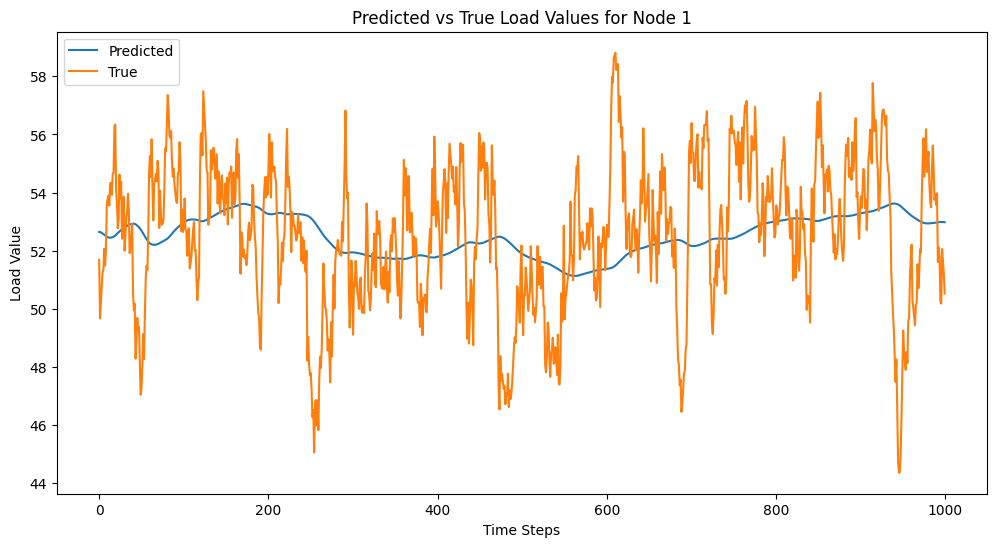

In [12]:
# 转换预测值和真实值为 NumPy 数组
predictions = np.array(predictions)
true_values = np.array(true_values)
# 输出图像
plt.figure(figsize=(12, 6))

# 假设你想绘制第一个节点的预测结果
plt.plot(predictions[:, 0], label='Predicted')
plt.plot(true_values[:, 0], label='True')
plt.xlabel('Time Steps')
plt.ylabel('Load Value')
plt.title('Predicted vs True Load Values for Node 1')
plt.legend()

# 显示图像
plt.show()